In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

# Data preparation

In [2]:
data = pd.read_csv('full_data_labeled.csv')
data = data.drop(columns=['CI SCORE GLOVE','CI SCORE GLOVE 2','CI SCORE GLOVE 50','CI MEAN SCORES']).replace(np.nan,'None')
print(data.shape)

df = data.copy()
df['LabelEncoded'] = df['Label'].replace(['no','yes'],[0,1])
df = df.drop(columns=['Vulnerability Type(s)','Vulnerability Name','Kmeans_clusters','CI SCORE','Label'])

df = df[df['Authentication']!='Single system']
df = df[df['Access']!='Unknown']
df = df.reset_index().drop(columns=['level_0'])

print(df.shape)

numerical_cols = ['Score','Number Of Related Vulnerabilities']
categorical_cols = ['Access','Complexity', 'Authentication', 'Conf.', 'Integ.', 'Avail']
# categorical_cols = ['Vulnerability Type(s)', 'Vulnerability Name', 'Access',
#                     'Complexity', 'Authentication', 'Conf.', 'Integ.', 'Avail']
label = ['LabelEncoded']

ohe = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    df[numerical_cols]
],axis=1)

from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()
std_scaler = stdScaler.fit_transform(df[numerical_cols])
ohe_std_scaled = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    pd.DataFrame(std_scaler,columns=numerical_cols)
],axis=1)
# Scaling all features
std_scaler_all = stdScaler.fit_transform(ohe)
ohe_all_scaled = pd.DataFrame(std_scaler_all,columns=ohe.columns)

from sklearn.preprocessing import MinMaxScaler 
mnScaler = MinMaxScaler()
mn_scaler = mnScaler.fit_transform(df[numerical_cols])
ohe_mn_scaled = pd.concat([
    pd.get_dummies(df[categorical_cols],dtype=float),
    pd.DataFrame(mn_scaler,columns=numerical_cols)
],axis=1)
print(ohe_mn_scaled.shape)



from imblearn.under_sampling import RandomUnderSampler
X = ohe_mn_scaled
y = df[label]
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)



(61698, 14)
(52634, 10)
(52634, 19)


In [3]:
print(y.value_counts())
print(y_rus.value_counts())

LabelEncoded
1               43818
0                8816
Name: count, dtype: int64
LabelEncoded
0               8816
1               8816
Name: count, dtype: int64


#

# Training and ploting function

In [4]:

from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, f1_score



def train_model(X,Y,model):
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=99)
    cv = ShuffleSplit(test_size=0.2)
    cv_results = cross_validate(model,X=X_train,y=y_train,cv=cv,return_train_score=True, error_score='raise')
    print("Train Score:", f"{cv_results['train_score'].mean():.4f}")
    
    cross_val_scores = cross_val_score(model,X=X_train,y=y_train, cv=cv)
    print("Mean CV Score:", f"{cross_val_scores.mean():.4f}")
    
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print("Train Score:", f"{train_score:.4f}")
    print("Test Score:", f"{test_score:.4f}")
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(f"accuracy {accuracy_score(y_test,y_pred):.4f}")
    print(f"f1_score {f1_score(y_test,y_pred):.4f}")
    

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Class 0', 'Class 1'])
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # Display confusion matrix values
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='black')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()




In [5]:

# Classification models :
from sklearn.neighbors import NearestCentroid # Test Score: 0.91  # Tuning: (shrink_threshold=0.3) = 0.92
from sklearn.naive_bayes import MultinomialNB # Test Score: 0.94  # Tuning: (alpha=10, fit_prior=False) = 0.95
from sklearn.naive_bayes import BernoulliNB # Test Score: 0.90    # Tuning: 0.99 overtif so use default
from sklearn.naive_bayes import ComplementNB # Test Score: 0.95   # Tuning: no effect so use default
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
# Test Score: 0.72 # Tuning: (reg_param=0.1, store_covariance=True) = 0.95

from sklearn.naive_bayes import CategoricalNB # Test Score: 0.90
from sklearn.svm import NuSVC # Test Score: 0.91 - exe:7min


# train_model(
#     X = X_rus,
#     Y = y_rus,
#     model = BernoulliNB()
#     )


#

# Hyperparams tuninig function

In [6]:

def tuning(X, Y, clf, param_grid):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
    grid_search = GridSearchCV(clf, param_grid, cv=10)
    grid_search.fit(X_train, y_train)
    
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best estimator:", grid_search.best_estimator_)
    print("Best Score:", grid_search.best_score_)

    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    
    

param_grid_NearestCentroid = {
    'shrink_threshold': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
}#Best estimator: NearestCentroid(shrink_threshold=0.3)

param_grid_MultinomialNB = {
    'alpha': [0, 0.1, 1.0, 2.0, 10, 100, 1000],
    'fit_prior': [True,False]
}#Best estimator: MultinomialNB(alpha=10, fit_prior=False)

param_grid_QuadraticDiscriminantAnalysis = {
    'reg_param': [0.0, 0.1, 0.2],
    'store_covariance': [True, False],
}#Best estimator: QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True)


Train Score: 0.9094
Mean CV Score: 0.9107
Train Score: 0.9094
Test Score: 0.9062
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      2120
           1       0.85      0.97      0.91      2005

    accuracy                           0.91      4125
   macro avg       0.91      0.91      0.91      4125
weighted avg       0.91      0.91      0.91      4125

[[1786  334]
 [  53 1952]]
0.9062


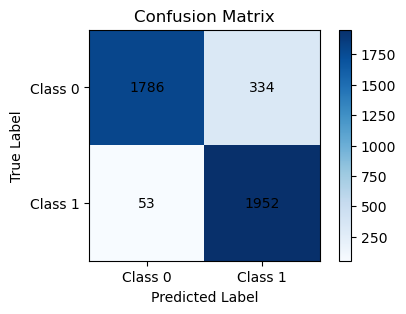

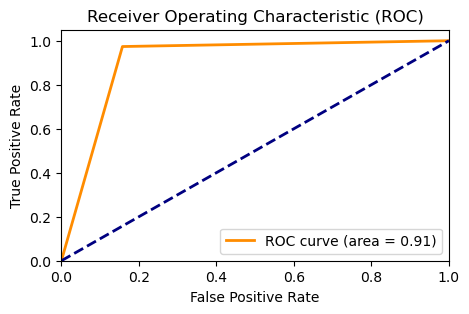


=========	After Tuning	==========

Best hyperparameters: {'alpha': 10, 'fit_prior': True}
Best estimator: MultinomialNB(alpha=10)
Best Score: 0.914177040263153
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      2013
           1       0.99      0.84      0.91      2112

    accuracy                           0.91      4125
   macro avg       0.92      0.91      0.91      4125
weighted avg       0.92      0.91      0.91      4125

0.9105454545454545


In [7]:


# Before Tuning
train_model(X = X_rus,
            Y = y_rus,
            model = NearestCentroid())
print('\n=========\tAfter Tuning\t==========\n')
# After Tuning
tuning(X = X_rus,
       Y = y_rus,
       clf = MultinomialNB(),
       param_grid = param_grid_MultinomialNB)



# 

# Voting Ensemble

In [11]:

from sklearn.ensemble import VotingClassifier

nc_clf = NearestCentroid(shrink_threshold=0.3)
mulnb_clf = MultinomialNB(alpha=10, fit_prior=False)
qda_clf = QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True)
bernb_clf = BernoulliNB()
comnb_clf = ComplementNB()

# NN_clf = keras.Sequential([
#     keras.layers.Dense(1,input_shape=(X_rus.shape[1],),activation='sigmoid')
# ]).compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# NN_clf.fit(x_train, y_train, epochs=3)


voting_clf = VotingClassifier([
    ('nc_clf',nc_clf),
    ('mulnb_clf',mulnb_clf),
    ('qda_clf',qda_clf),
    ('bernb_clf',bernb_clf),
    ('comnb_clf',comnb_clf),
])


X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2)
nc_clf.fit(X_train,y_train)
mulnb_clf.fit(X_train,y_train)
qda_clf.fit(X_train,y_train)
bernb_clf.fit(X_train,y_train)
comnb_clf.fit(X_train,y_train)

print("nc_clf : ",nc_clf.score(X_test,y_test))
print("mulnb_clf : ",mulnb_clf.score(X_test,y_test))
print("qda_clf : ",qda_clf.score(X_test,y_test))
print("bernb_clf : ",bernb_clf.score(X_test,y_test))
print("comnb_clf : ",comnb_clf.score(X_test,y_test))
print("\n=================================")

voting_clf.fit(X_train,y_train)
print("voting_clf trainig : ",voting_clf.score(X_train,y_train))
y_pred = voting_clf.predict(X_test)
print("voting_clf testing: ",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))



nc_clf :  0.9778848880068046
mulnb_clf :  0.9824213212361781
qda_clf :  0.9832719024666856
bernb_clf :  0.980720158775163
comnb_clf :  0.9824213212361781

voting_clf trainig :  0.982346685572492
voting_clf testing:  0.9824213212361781
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1773
           1       0.98      0.99      0.98      1754

    accuracy                           0.98      3527
   macro avg       0.98      0.98      0.98      3527
weighted avg       0.98      0.98      0.98      3527



In [12]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1773
           1       0.98      0.99      0.98      1754

    accuracy                           0.98      3527
   macro avg       0.98      0.98      0.98      3527
weighted avg       0.98      0.98      0.98      3527



#

# Models Comparison

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


nc_clf = NearestCentroid(shrink_threshold=0.3)
mulnb_clf = MultinomialNB(alpha=10, fit_prior=False)
qda_clf = QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True)
lda_clf = LinearDiscriminantAnalysis()
bernb_clf = BernoulliNB()
comnb_clf = ComplementNB()
svc_clf = SVC()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
voting_clf = VotingClassifier([
        ('nc_clf',nc_clf),
        ('mulnb_clf',mulnb_clf),
        ('qda_clf',qda_clf),
        ('bernb_clf',bernb_clf),
        ('comnb_clf',comnb_clf),
    ])


# Create a list of classifiers
classifiers = [
    ('NearestCentroid', nc_clf),
    ('MultinomialNB', mulnb_clf),
    ('QuadraticDiscriminantAnalysis', qda_clf),
    ('LinearDiscriminantAnalysis', lda_clf),
    ('BernoulliNB', bernb_clf),
    ('ComplementNB', comnb_clf),
    ('SVC', svc_clf),
    ('KNeighborsClassifier', knn_clf),
    ('DecisionTreeClassifier', dt_clf),
    ('LogisticRegression', lr_clf),
    ('RandomForestClassifier', rf_clf),
    ('VotingClassifier', voting_clf),
]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=99)


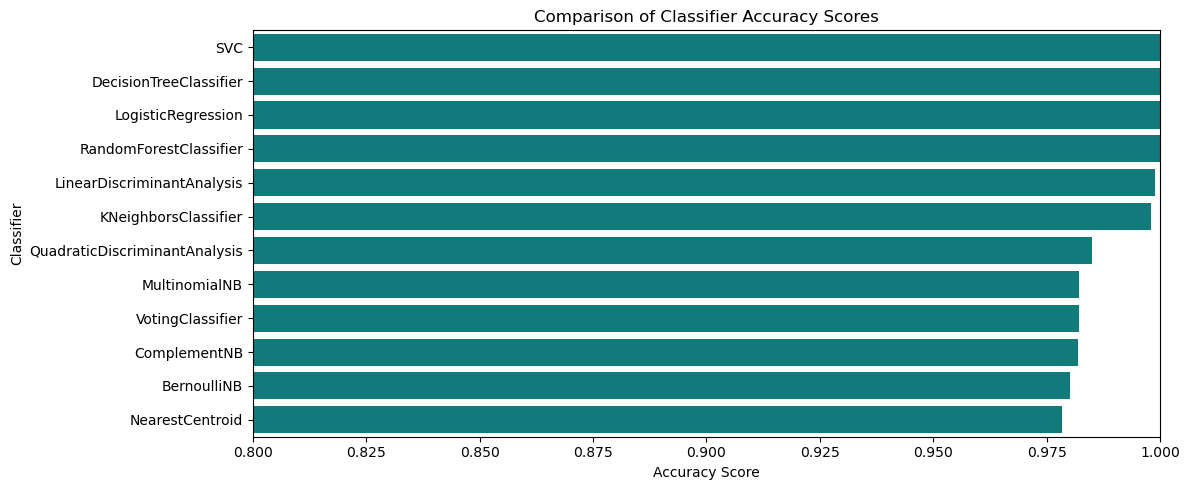

In [24]:


# Train and evaluate each classifier
accuracy_scores = []
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append({'Classifier': name, 'Accuracy': accuracy})

# Create a DataFrame to store the results
results_df = pd.DataFrame(accuracy_scores)

# Sort the DataFrame by accuracy score
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Create a horizontal bar plot to compare accuracy scores
plt.figure(figsize=(12, 5))
sns.barplot(x='Accuracy', y='Classifier', data=results_df, color='darkcyan')
plt.xlabel('Accuracy Score')
plt.ylabel('Classifier')
plt.title('Comparison of Classifier Accuracy Scores')
plt.xlim(0.8, 1.0)  # Set the x-axis range
plt.tight_layout()
plt.show()


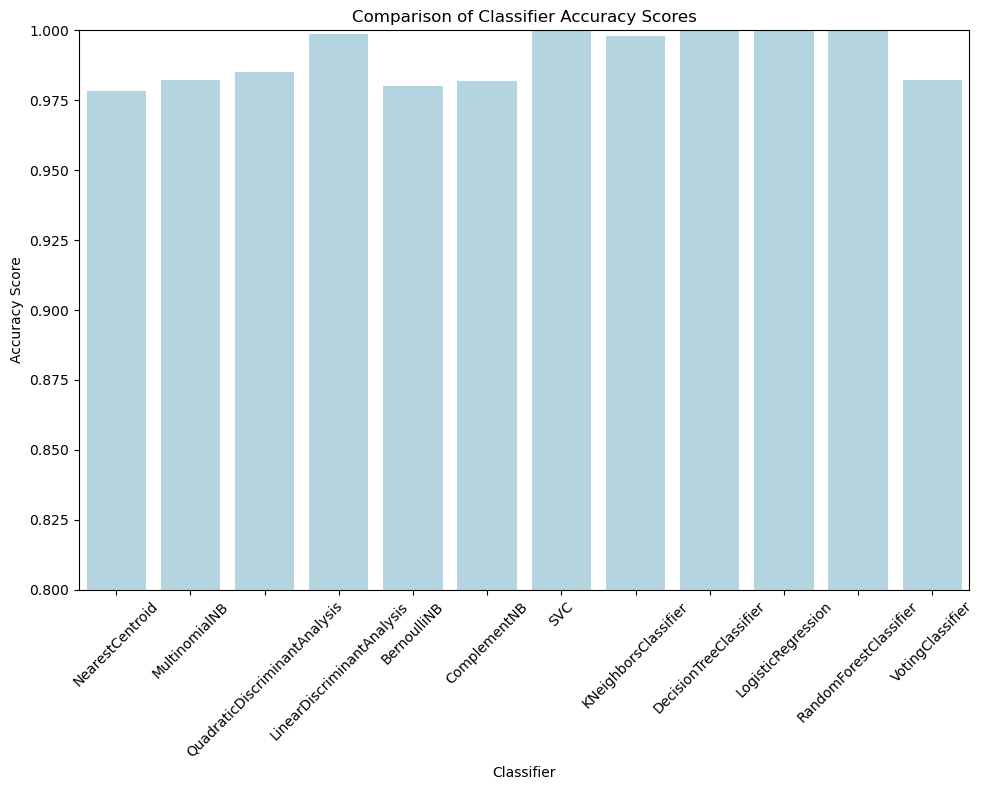

In [18]:

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=99)


# Train and evaluate each classifier
accuracy_scores = []
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append({'Classifier': name, 'Accuracy': accuracy})

# Create a DataFrame to store the results
results_df = pd.DataFrame(accuracy_scores)

# Set the range of values on the y-axis
y_range = (0.8, 1.0)  # Adjust the range as needed

# Create a box plot to compare accuracy scores
plt.figure(figsize=(10, 8))
sns.barplot(x='Classifier', y='Accuracy', data=results_df, color='lightblue')
plt.xlabel('Classifier')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Classifier Accuracy Scores')
plt.xticks(rotation=45)
plt.ylim(y_range)  # Set the y-axis range
plt.tight_layout()
plt.show()


#

# Voting CM

Train Score: 0.9826
Mean CV Score: 0.9828
Train Score: 0.9824
Test Score: 0.9821
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1772
           1       0.98      0.99      0.98      1755

    accuracy                           0.98      3527
   macro avg       0.98      0.98      0.98      3527
weighted avg       0.98      0.98      0.98      3527

[[1733   39]
 [  24 1731]]
accuracy 0.9821
f1_score 0.9821


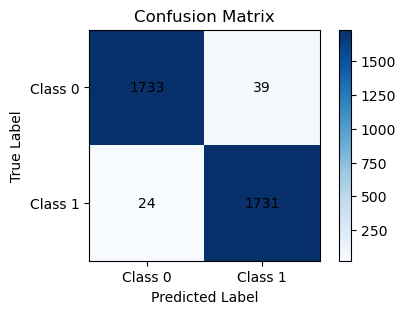

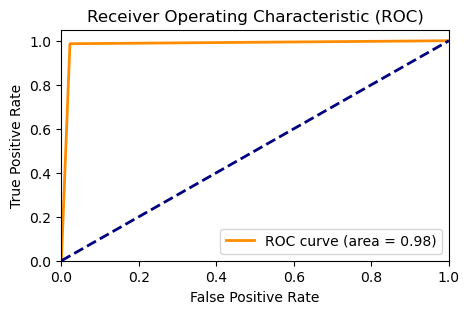

In [20]:


# with unknowen values
train_model(
    
    X = X_rus,
    Y = y_rus,
    model = VotingClassifier([
        ('nc_clf',nc_clf),
        ('mulnb_clf',mulnb_clf),
        ('qda_clf',qda_clf),
        ('bernb_clf',bernb_clf),
        ('comnb_clf',comnb_clf),
    ])
)



Train Score: 0.9833
Mean CV Score: 0.9829
Train Score: 0.9833
Test Score: 0.9827
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1772
           1       0.98      0.99      0.98      1755

    accuracy                           0.98      3527
   macro avg       0.98      0.98      0.98      3527
weighted avg       0.98      0.98      0.98      3527

[[1733   39]
 [  22 1733]]
0.9827


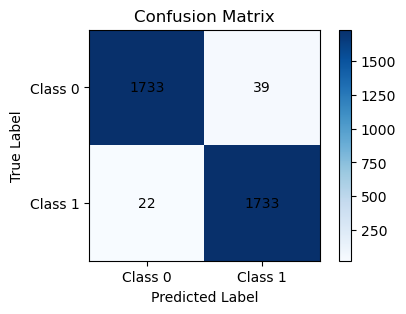

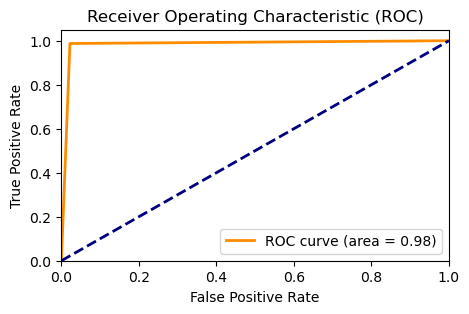

In [65]:

# without unknowen values
train_model(
    
    X = X_rus,
    Y = y_rus,
    model = VotingClassifier([
        ('nc_clf',nc_clf),
        ('mulnb_clf',mulnb_clf),
        ('qda_clf',qda_clf),
        ('bernb_clf',bernb_clf),
        ('comnb_clf',comnb_clf),
    ])
)


#

# Learning Curve

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2,random_state=99)

# Define models 
model = VotingClassifier([
        ('nc_clf',nc_clf),
        ('mulnb_clf',mulnb_clf),
        ('qda_clf',qda_clf),
        ('bernb_clf',bernb_clf),
        ('comnb_clf',comnb_clf),
    ])

# Define train sizes for learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate learning curve scores
train_sizes_abs, train_scores, test_scores = learning_curve(
    model, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=-1
)


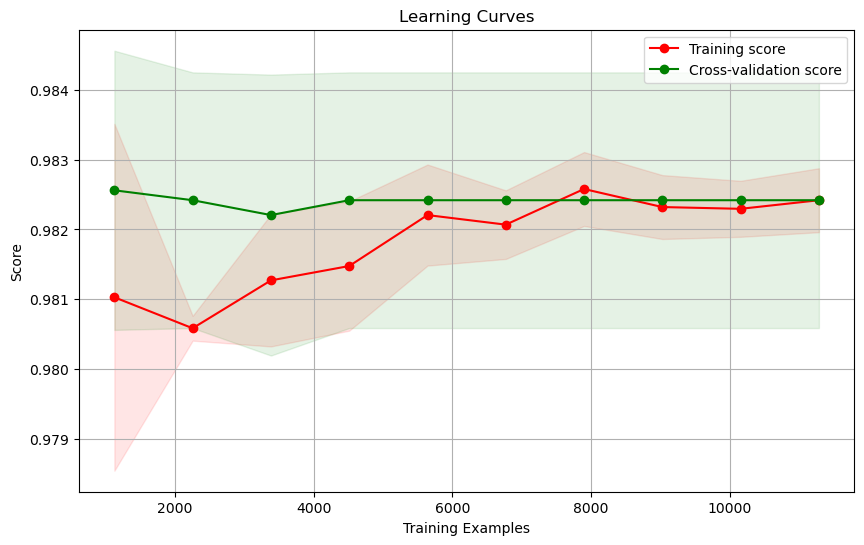

In [26]:

# Calculate mean and standard deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.title("Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(
    train_sizes_abs,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes_abs,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes_abs, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(
    train_sizes_abs, test_scores_mean, "o-", color="g", label="Cross-validation score"
)

plt.legend(loc="best")
plt.show()


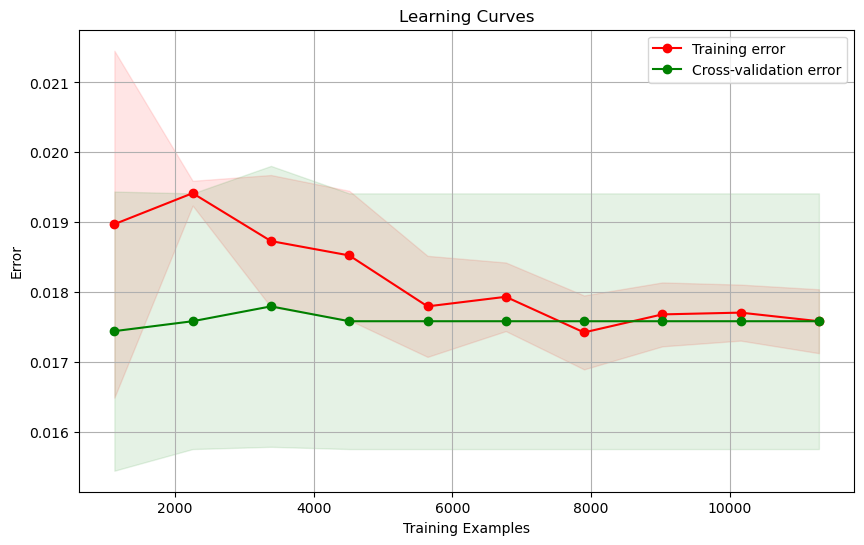

In [27]:

# Convert scores to errors
train_errors = 1 - train_scores
test_errors = 1 - test_scores

# Calculate mean and standard deviation of errors
train_errors_mean = np.mean(train_errors, axis=1)
train_errors_std = np.std(train_errors, axis=1)
test_errors_mean = np.mean(test_errors, axis=1)
test_errors_std = np.std(test_errors, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.title("Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Error")
plt.grid()

plt.fill_between(
    train_sizes_abs,
    train_errors_mean - train_errors_std,
    train_errors_mean + train_errors_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes_abs,
    test_errors_mean - test_errors_std,
    test_errors_mean + test_errors_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes_abs, train_errors_mean, "o-", color="r", label="Training error")
plt.plot(
    train_sizes_abs, test_errors_mean, "o-", color="g", label="Cross-validation error"
)

plt.legend(loc="best")
plt.show()


# 

# Predictions

In [28]:
X_test.head(1)
print('Prediction :',voting_clf.predict(X_test.head(1)))

cols = ['Access', 'Complexity', 'Authentication', 'Conf.', 'Integ.','Avail']
for col in cols:
    print(df[col].nunique(),'\t',df[col].unique(),'\t',col)

# shape should be (1, 19)

Prediction : [0]
3 	 ['Remote' 'Local' 'Local Network'] 	 Access
3 	 ['Medium' 'Low' 'High'] 	 Complexity
2 	 ['Not required' 'Unknown'] 	 Authentication
3 	 ['None' 'Partial' 'Complete'] 	 Conf.
3 	 ['Partial' 'None' 'Complete'] 	 Integ.
3 	 ['None' 'Partial' 'Complete'] 	 Avail


In [29]:

# df.sample(50).drop(columns=['index','LabelEncoded']).to_csv('sample_data_labeled_for_predictions.csv',index=False)
df_predictions = pd.read_csv('sample_data_labeled_for_predictions.csv').replace(np.nan,'None')

# asuuming that we get this data from a http request
input_data = {
    'Access': ['Local'],
    'Complexity': ['High'],
    'Authentication': ['Not required'],
    'Conf.': ['Complete'],
    'Integ.': ['Partial'],
    'Avail': ['Complete'],
    'Score': [9.3],
    'Number Of Related Vulnerabilities': [413]
}
df_input_data = pd.DataFrame(input_data)

# add the new record to our data sample for ohe and scale
df_pred_input = pd.concat([df_predictions,df_input_data],axis=0).reset_index().drop(columns=['index'])
numerical_columns = df_pred_input.select_dtypes(include=['int', 'float']).columns
categorical_columns = df_pred_input.select_dtypes(exclude=['int', 'float']).columns

# process new input data for predict it
from sklearn.preprocessing import MinMaxScaler 
mnScaler = MinMaxScaler()
df_predictions_scaled = pd.concat([
    pd.get_dummies(df_pred_input[categorical_columns],dtype=float),
    pd.DataFrame(mnScaler.fit_transform(df_pred_input[numerical_columns]),columns=numerical_columns)
],axis=1)

new_input_processed = df_predictions_scaled.tail(1)
print('input shape :',new_input_processed.shape)
print('Prediction :',voting_clf.predict(new_input_processed))
new_input_processed

input shape : (1, 19)
Prediction : [1]


,Access_Local,Access_Local Network,Access_Remote,Complexity_High,Complexity_Low,Complexity_Medium,Authentication_Not required,Authentication_Unknown,Conf._Complete,Conf._None,Conf._Partial,Integ._Complete,Integ._None,Integ._Partial,Avail_Complete,Avail_None,Avail_Partial,Score,Number Of Related Vulnerabilities
50,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.91358,0.017989


In [30]:
new_input_processed = df_predictions_scaled.tail(1)
print('Prediction :',voting_clf.predict(new_input_processed))

Prediction : [1]


In [31]:
df_input_data

,Access,Complexity,Authentication,Conf.,Integ.,Avail,Score,Number Of Related Vulnerabilities
0,Local,High,Not required,Complete,Partial,Complete,9.3,413


In [32]:
np.hstack(y_test[:20].values)

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
      dtype=int64)

In [33]:
voting_clf.predict(X_test[:20])

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
      dtype=int64)

#

# Save the model

In [35]:
voting_clf

VotingClassifier(estimators=[('nc_clf', NearestCentroid(shrink_threshold=0.3)),
                             ('mulnb_clf',
                              MultinomialNB(alpha=10, fit_prior=False)),
                             ('qda_clf',
                              QuadraticDiscriminantAnalysis(reg_param=0.1,
                                                            store_covariance=True)),
                             ('bernb_clf', BernoulliNB()),
                             ('comnb_clf', ComplementNB())])


In [69]:
# Export the model in binary file

import pickle

model = voting_clf
filename = 'model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to {filename}")

Model saved to model.pkl


In [72]:
# Load the model from the binary file

filename = 'model.pkl'
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

input_data = new_input_processed
predictions = loaded_model.predict(input_data)
print('predictions:',predictions)

predictions: [1]


In [73]:
print(df_predictions.columns)

Index(['Access', 'Complexity', 'Authentication', 'Conf.', 'Integ.', 'Avail',
       'Score', 'Number Of Related Vulnerabilities'],
      dtype='object')
